In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from tqdm import tqdm
import seaborn
import torch
import torch.nn as nn
BILICOUGH_ROOT = "E:/DATAS-Medical/BILIBILICOUGH/"

# explore

In [2]:
metadf = pd.read_csv(BILICOUGH_ROOT+"bilicough_metainfo.csv", delimiter=',', header=0, index_col=None, encoding="ansi")
print(metadf)
newdf = metadf
newdf["binlab"] = newdf["label"].apply(lambda x:2 if x==2 else 0)
newdf

           filename       st       en        labelfull labelname  label
0     bilicough_000  00:01.0  00:01.7            cough     cough      2
1     bilicough_000  00:01.7  00:02.2            cough     cough      2
2     bilicough_000  00:02.2  00:02.7            cough     cough      2
3     bilicough_000  00:03.0  00:03.4            cough     cough      2
4     bilicough_000  00:03.4  00:04.0            cough     cough      2
...             ...      ...      ...              ...       ...    ...
1266  bilicough_018  01:51.3  01:52.3         whooping  whooping     11
1267  bilicough_018  01:52.5  01:52.8  cough(whooping)     cough      2
1268  bilicough_018  01:52.8  01:53.1  cough(whooping)     cough      2
1269  bilicough_018  01:53.1  01:53.5  cough(whooping)     cough      2
1270  bilicough_018  01:54.1  01:55.4           speech    speech      9

[1271 rows x 6 columns]


,filename,st,en,labelfull,labelname,label,binlab
0,bilicough_000,00:01.0,00:01.7,cough,cough,2,2
1,bilicough_000,00:01.7,00:02.2,cough,cough,2,2
2,bilicough_000,00:02.2,00:02.7,cough,cough,2,2
3,bilicough_000,00:03.0,00:03.4,cough,cough,2,2
4,bilicough_000,00:03.4,00:04.0,cough,cough,2,2
...,...,...,...,...,...,...,...
1266,bilicough_018,01:51.3,01:52.3,whooping,whooping,11,0
1267,bilicough_018,01:52.5,01:52.8,cough(whooping),cough,2,2
1268,bilicough_018,01:52.8,01:53.1,cough(whooping),cough,2,2
1269,bilicough_018,01:53.1,01:53.5,cough(whooping),cough,2,2


<BarContainer object of 10 artists>

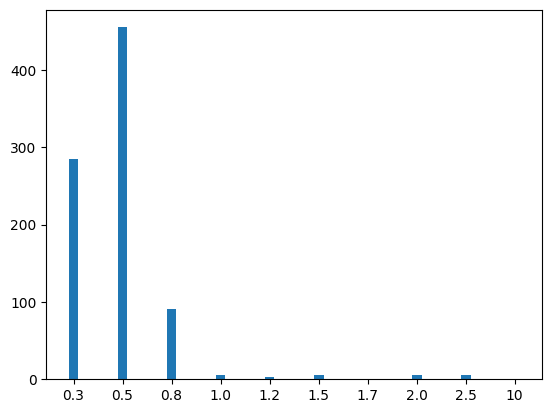

In [3]:
def min2sec(t: str):
    parts = t.split(':')
    res = float(parts[-1])
    f = 60
    for i in range(len(parts)-1):
        res += int(parts[len(parts)-2-i]) * f
        f *= 60
    return res
sn_list = []
sr = 22050
for ind, item in enumerate(metadf.itertuples()):
    # print("key:{},\tcount:{}, st:{}, en:{}, {}, {}".format(ind, item[1], item[2], item[3], item[5], item[6]))
    if item[6] == 2:
        st, en = int(min2sec(item[2])*sr), int(min2sec(item[3])*sr+1)
        sn = en - st
        sn_list.append((en - st)/22050)

# plt.hist(sn_list, bins=12)

trs = [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 1.7, 2.0, 2.5, 10]
cnt_list = [0] * len(trs)
for sn in sn_list:
    for i in range(len(trs)):
        if sn < trs[i]+0.1:
            cnt_list[i] += 1
            break
plt.figure(0)
plt.bar([str(item) for item in trs], cnt_list, width=0.2)

# Train Start

In [ ]:
def get_bilicough_dataset():
    ROOT = "G:/DATAS-Medical/BILIBILICOUGH/"
    metadf = pd.read_csv(ROOT+"bilicough_metainfo.csv", delimiter=',', header=0, index_col=None, usecols=[0,1,2,5], encoding="ansi")
    print(metadf)
    cur_fname = None
    cur_wav = None
    data_length = None
    sample_list = []
    label_list = []
    sr_list = []
    pre_st, pre_en = None, None
    # filename	st	en	labelfull	labelname	label	binlab
    for ind, item in enumerate(metadf.itertuples()):
        if (cur_fname != item[1]) or (cur_fname is None):
            cur_fname = item[1]
            cur_wav, sr = librosa.load(ROOT+cur_fname+".wav")
            if sr not in sr_list:
                sr_list.append(sr)
            data_length = sr
        st, en = int(min2sec(item[2])*sr), int(min2sec(item[3])*sr+1)
        if en > len(cur_wav):
            en = len(cur_wav)
        if en - st < 100:
            raise Exception("Error Index.")
        sn = en - st
        # sec = (en - st)/22050
        if (pre_en is None):
            if st >= data_length:
                st_pos = 0
                ind = 0
                while st_pos + data_length <= st:
                    # if len(cur_wav[st_pos:st_pos+data_length]) != sr:
                    #     raise Exception("Error Length.")
                    sample_list.append(cur_wav[st_pos:st_pos+data_length])
                    label_list.append(0)
                    st_pos += data_length
                    ind += 1
                    if ind >2:
                        break
                sample_list.append(cur_wav[st-data_length:st])
                label_list.append(0)
        else:
            if st - pre_en >= sr:
                st_pos = pre_en
                ind = 0
                while st_pos + data_length <= st:
                    # if len(cur_wav[st_pos:st_pos+data_length]) != sr:
                    #     raise Exception("Error Length.")
                    sample_list.append(cur_wav[st_pos:st_pos+data_length])
                    label_list.append(0)
                    st_pos += data_length
                    ind += 1
                    if ind > 2:
                        break
                sample_list.append(cur_wav[st-data_length:st])
                label_list.append(0)
        label = int(item[4])
        if sn==data_length:
            # if len(cur_wav[st:en]) != sr:
            #     raise Exception("Error Length.")
            sample_list.append(cur_wav[st:en])
            if label in [6, 7]:
                label_list.append(0)
            else:
                label_list.append(1)
        elif sn < data_length:
            new_sample = np.zeros(data_length)
            # print(st, en, sn, len(cur_wav), item[1])
            if en <= len(cur_wav):
                new_sample[:sn] = cur_wav[st:en]
            else:
                new_sample[:sn] = cur_wav[len(cur_wav)-sn:len(cur_wav)]
            # if len(new_sample) != sr:
            #     raise Exception("Error Length.")
            sample_list.append(new_sample)
            if label in [6, 7]:
                label_list.append(0)
            else:
                label_list.append(1)
        else:
            cnt_sum = sn // data_length + 1
            res = cnt_sum * data_length - sn
            overlap = res // (cnt_sum-1)
            st_pos = st
            while st_pos + data_length < en:
                # if len(cur_wav[st_pos:st_pos+data_length]) < data_length: 
                #     tmp_length = len(cur_wav[st_pos:st_pos+data_length])
                #     print(data_length, tmp_length)
                #     # raise Exception("Error Length.")
                #     print("Error Length.")
                #     new_sample = np.zeros(data_length)
                #     new_sample[:tmp_length] = cur_wav[st_pos:st_pos+data_length]
                #     sample_list.append(new_sample)
                # else:
                #     sample_list.append(cur_wav[st_pos:st_pos+data_length])  
                sample_list.append(cur_wav[st_pos:st_pos+data_length])                
                if label in [6, 7]:
                    label_list.append(0)
                else:
                    label_list.append(1)
                st_pos += data_length - overlap
            sample_list.append(cur_wav[en-data_length:en])
            label_list.append(1)
        pre_st, pre_en = st, en
    print("sound count:{}, all count:{}.".format(sum(label_list), len(label_list)))
    print(sr_list)
    return sample_list, label_list

sample_list, label_list = get_bilicough_dataset()
length_list = []
for item in sample_list:
    if len(item) not in length_list:
        length_list.append(len(item))
print(length_list)

### 添加噪声数据

In [ ]:
def load_bilinoise_dataset():
    NOISE_ROOT = "G:/DATAS-Medical/BILINOISE/"
    noise_length = None
    filter_length = 25
    ind = 0
    new_noise_list = []
    for item in os.listdir(NOISE_ROOT):
        if item[-4:] == ".wav" and len(item)>=filter_length:
            cur_fname = NOISE_ROOT+item
            cur_wav, sr = librosa.load(cur_fname)
            noise_length = sr
            L = len(cur_wav)
            st_pos = np.random.randint(0, L-noise_length)
            new_noise_list.append(cur_wav[st_pos:st_pos+noise_length])
            # print(NOISE_ROOT+item)
        ind += 1
        if ind > 18:
            break
    for item in new_noise_list:
        print(len(item))

def addnoise(w, a):
    if len(w) != len(a):
        raise ValueError("The length of waveform and noise are not equal, and can't be added together!")
    return w+a



# 创建神经网络

## 注意到，频域决定类别、幅值和时长是干扰因素，因为想办法在这里入手
### 频域多用全连接而不是卷积池化
### 幅值多用normalization
### 时长采用多尺度叠加

In [2]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataSet, DataLoader

sys.path.append(r'D:/PythonTorchVITS/MedicalSignal/SoundDL-CoughVID')
from chapter2_VADmodel import VADModel

In [3]:
vad_model = VADModel()
# tdnn = TDNN_Extractor()
x = torch.rand(size=(16, 1, 22050))
print(vad_model(x).shape)

wav feat shape: torch.Size([16, 32, 1024])
mel shape torch.Size([16, 1, 64, 44])
mel feat shape: torch.Size([16, 16, 64, 32])
mel feat shape: torch.Size([16, 32, 1024])
feat shape: torch.Size([16, 32, 2048])
torch.Size([16, 512])
torch.Size([16])


In [11]:
import random
a = [1,2,3,4,5,6]
a[random.randint(0, len(a))]

2

In [6]:
class BiliCoughDataset(DataSet):
    def __init__(self, audioseg, labellist, noises):
        self.audioseg = audioseg
        self.labellist = labellist
        self.noises = noises
    def __getitem__(self, ind):
        return self.audioseg[ind]+self.noises[random.randint(0, len(self.noises))], self.labellist[ind]
    def __len__(self):
        return len(self.audioseg)

NameError: name 'DataSet' is not defined

In [ ]:
# 假设你已经有了train_loader和valid_loader
trte_rate = int(len(sample_list)*0.9)

train_loader = DataLoader(BiliCoughDataset(sample_list[:trte_rate], label_list[:trte_rate], noise_list),
                          batch_size=32, shuffle=True)
valid_loader = DataLoader(BiliCoughDataset(sample_list[trte_rate:], label_list[trte_rate:], noise_list),
                          batch_size=32, shuffle=False)

# 初始化模型、损失函数和优化器
model = VAEModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练流程
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, (waveform, melspectrogram, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(waveform, melspectrogram)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 10 == 9:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}')
                running_loss = 0.0

# 验证流程
def validate(model, valid_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for waveform, melspectrogram, labels in valid_loader:
            outputs = model(waveform, melspectrogram)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the validation set: {100 * correct / total:.2f}%')

# 训练和验证
train(model, train_loader, criterion, optimizer, epochs=10)
validate(model, valid_loader, criterion)

In [1]:
a = np.array([1,2,43,])
b = np.array([5,76,8,])
c = np.array([4,8,6])
print(np.concatenate((np.array([]), a, b,c), axis=0))
arr= np.array([1,5,7,8,65,4,6,8,9,0])
print(arr[8:15])

NameError: name 'np' is not defined